# The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [2]:
import pandas as pd

# Read stuff
df = pd.read_csv('breast-cancer.data', header=None, 
                 names=['target','age', 'menopause', 'tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad', 'irradiat'])

In [3]:
from sklearn import preprocessing

# Encode to number
for col in df.columns:
    le = preprocessing.LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])

In [4]:
# Split data and target
df_data = df.drop(['target'], axis=1)
y = df.target

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(123123)

# Split train, test
df_train, df_test, y_train, y_test = train_test_split(df_data, y.values, test_size=0.2)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
# Test score
model.score(df_test, y_test)

0.7758620689655172

In [8]:
# F1 score 
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(df_test))

0.38095238095238093

<BarContainer object of 9 artists>

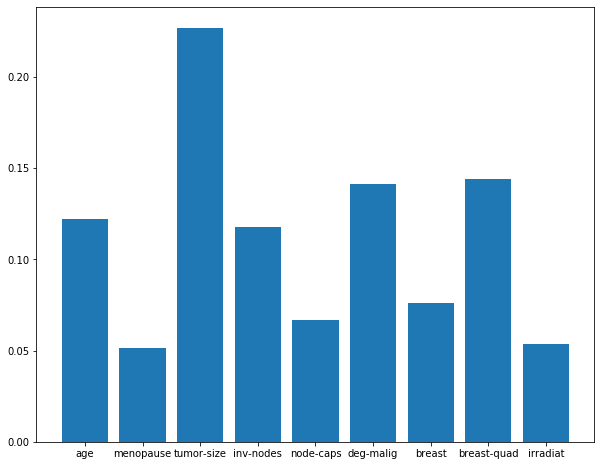

In [9]:
plt.figure(figsize=(10,8))
plt.bar(df_train.columns, model.feature_importances_)

# Quantum dude

In [11]:
# Get most important col
# n columns
col_num = 3
mvp_col = ['tumor-size', 'breast-quad', 'deg-malig']

In [12]:
# Get only MVP columns

df_train_q = df_train[mvp_col].values
df_test_q = df_test[mvp_col].values

In [13]:
from qiskit import IBMQ
provider = IBMQ.load_account()

In [14]:
def double(x):
    return np.concatenate([x, x], axis=0)

# len(double(df_train_encode[y_train == 0]))

In [15]:
training_input = {
    0: df_train_q[y_train == 0],
    1: double(df_train_q[y_train == 1])
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}

In [16]:
training_input[1].shape

(142, 3)

In [76]:
#  Stupid Ordinal input

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)
    
    
# var_form = TwoLocal(2, ['ry'], 'cx', entanglement='circular', reps=1, insert_barriers=True)
var_form = variational_forms.RYRZ(2)

feature_map = ZZFeatureMap(feature_dimension=len(mvp_col), reps=3, entanglement='linear')

qsvm = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
            The <class 'qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  from ipykernel import kernelapp as app
2020-07-09 20:58:03,339:qi

KeyboardInterrupt: 

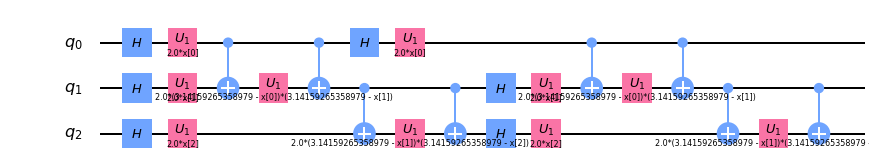

In [78]:
ZZFeatureMap(feature_dimension=len(mvp_col), reps=2, entanglement='linear').draw('mpl')

In [37]:
y_pred = qsvm.predict(df_test_q)[1]


# F1 score
np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 02:30:46,352:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.4482758620689655, 0.42857142857142855)

In [38]:
# Save model
# !mkdir models
qsvm.save_model('models/VQC_ordinal_3_features')

## Encode 3bits to 1qubit
So from $b_1b_2b_3\Rightarrow(\theta,\varphi)\ ; b_i\in\{-1,1\} $

In [39]:
df_q = df[mvp_col]

df_q.head()

,tumor-size,breast-quad,deg-malig
0,5,2,2
1,3,5,1
2,3,2,1
3,2,3,1
4,0,4,1


In [40]:
df_q = df[mvp_col]

data = []

for col_name in df_q.columns:
    num_cat = len(np.unique(df_q[col_name]))
    num_bit = int(np.ceil(np.log2(num_cat)))
    
    print(num_cat, num_bit)
    
    # Padding to x3 
    if num_bit % 3 != 0:
        num_bit = num_bit + (3 - (num_bit % 3))
        
        
    num_qubit = num_bit // 3

    features = []
    for size in df_q[col_name]:
        # Get last num_bit digit and reverse
        # 11 --> 001  | 011 --> 110 | 100
        
        all_b_st = f"{size:010b}"[-num_bit:][::-1]

        var_list = []
        for i in range(num_qubit):
            b_st = all_b_st[i * 3: (i+1) * 3]
            
            # b_st = b_1, b_2, b_3 = \sqrt{3}r_x, \sqrt{3}r_y, \sqrt{3}r_z

            if b_st[0] == '1':
                theta = np.arccos(1/np.sqrt(3))
            else:
                theta = np.arccos(-1/np.sqrt(3))

            if b_st[1] == '1' and b_st[2] == '1':
                varphi = np.pi / 4

            if b_st[1] == '1' and b_st[2] == '0':
                varphi = 3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '0':
                varphi = -3 * np.pi / 4

            if b_st[1] == '0' and b_st[2] == '1':
                varphi = -np.pi / 4

            var_list += [theta, varphi]

        features.append(var_list)
#         print(size, var_list)
    data.append(np.array(features))
    
data = np.concatenate(data, axis=1)

11 4
6 3
3 2


In [41]:
# Show ordinal data vs encoded
df_q.iloc[:5],data[:5]

(   tumor-size  breast-quad  deg-malig
 0           5            2          2
 1           3            5          1
 2           3            2          1
 3           2            3          1
 4           0            4          1,
 array([[ 0.95531662, -0.78539816,  2.18627604, -2.35619449,  2.18627604,
          2.35619449,  2.18627604,  2.35619449],
        [ 0.95531662,  2.35619449,  2.18627604, -2.35619449,  0.95531662,
         -0.78539816,  0.95531662, -2.35619449],
        [ 0.95531662,  2.35619449,  2.18627604, -2.35619449,  2.18627604,
          2.35619449,  0.95531662, -2.35619449],
        [ 2.18627604,  2.35619449,  2.18627604, -2.35619449,  0.95531662,
          2.35619449,  0.95531662, -2.35619449],
        [ 2.18627604, -2.35619449,  2.18627604, -2.35619449,  2.18627604,
         -0.78539816,  0.95531662, -2.35619449]]))

In [42]:
# Features for encoding

np.random.seed(123123)

df_train_encode, df_test_encode, y_train, y_test = train_test_split(data, y.values, test_size=0.2)

In [43]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


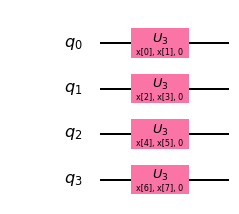

In [44]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [46]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 02:30:48,544:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-08 02:30:48,546:qiskit.aqua.algorithms.v

2020-07-08 02:37:03,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6777079585667909
2020-07-08 02:37:10,594:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6595710944939288
2020-07-08 02:37:17,268:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6821093552281404
2020-07-08 02:37:23,824:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6488349198163084
2020-07-08 02:37:30,615:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7208739275585728
2020-07-08 02:37:37,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6539109840909156
2020-07-08 02:37:43,823:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6570022492068676
2020-07-08 02:37:50,387:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6629536475267617
2020-07-08 02:37:56,863:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch

preduction of datapoints:


In [47]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-08 02:43:47,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.6885964912280702, 0.5359477124183006)

In [48]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 02:43:53,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.6551724137931034, 0.4736842105263159)

In [49]:
qsvm_encode.save_model('models/VQC_just_encode_model_3_feature')

# Model 2

In [179]:
df_test_encode.shape

(58, 8)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


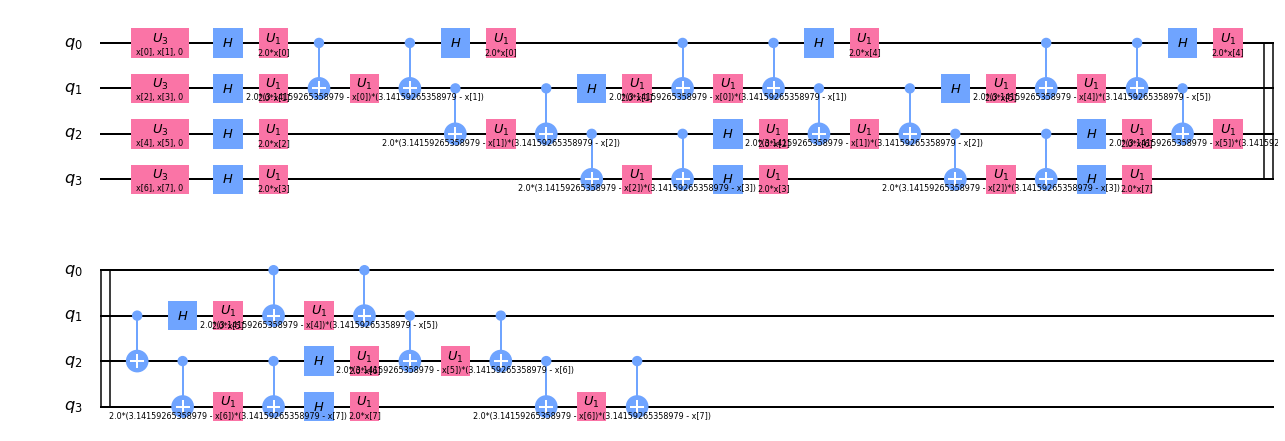

In [50]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter


num_qubits = data.shape[1] // 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(num_qubits * 2)]

var_form = variational_forms.RYRZ(num_qubits)

qc = QuantumCircuit(num_qubits)

for i in range(num_qubits):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
    

# Reassign the circuit variable
tmp1 = feature_map.assign_parameters(X[:num_qubits])
tmp2 = feature_map.assign_parameters(X[num_qubits:])

feature_map = qc + tmp1 + tmp2 
feature_map.draw('mpl')

In [51]:
# 

seed = 10598

vqc_encode_zz_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_zz_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 02:43:56,049:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-08 02:43:56,051:qiskit.aqua.algorithms.v

2020-07-08 02:54:13,054:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6372335164986936
2020-07-08 02:54:23,016:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6128811323989395
2020-07-08 02:54:33,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6164393309027493
2020-07-08 02:54:45,150:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6321953926332909
2020-07-08 02:54:55,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6337408363881105
2020-07-08 02:55:09,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6279022658805908
2020-07-08 02:55:24,307:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6430431076647046
2020-07-08 02:55:39,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6215727069334842
2020-07-08 02:55:50,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch

preduction of datapoints:


In [52]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-08 03:05:16,854:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7017543859649122, 0.5903614457831325)

In [53]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 03:05:26,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.46551724137931033, 0.24390243902439024)

In [54]:
qsvm_encode.save_model('models/VQC_encode_model_wt_ZZ_3_feature')

# Real Device

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


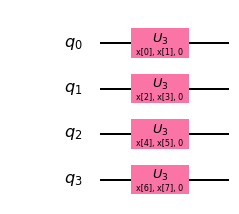

In [60]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [72]:
# 

seed = 10598

vqc_encode_only_real_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_real_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

provider = IBMQ.get_provider(hub='ibm-q-utokyo')
backend = provider.get_backend('ibmq_johannesburg')

# backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, optimization_level=3)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 20:47:41,374:qiskit.aqua.quantum_instance:WARNING: The skip Qobj validation does not work for IBMQ provider. Disable it.
2020-07-08 20:47:41,377:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'ibmq_johannesburg (<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='qc2020s')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id'], 'coupling_map': [[0, 1], [0, 5], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 

2020-07-08 20:51:09,704:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:15,043:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:20,726:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:26,112:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:31,773:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:37,411:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:43,058:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:48,477:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:54,149:qiskit.a

2020-07-08 20:57:00,015:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:05,666:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:11,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:16,954:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:22,628:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:28,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:33,910:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:39,549:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:45,258:qiskit.a

2020-07-08 21:03:10,567:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:16,229:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:21,868:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:27,256:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:32,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:38,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:44,040:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:49,677:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:55,294:qiskit.a

2020-07-08 21:09:10,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b676111e500014f72117, status: JobStatus.RUNNING
2020-07-08 21:09:19,740:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05b676111e500014f72117
2020-07-08 21:09:19,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7130390106698647
2020-07-08 21:09:41,567:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d49394198>
2020-07-08 21:09:41,572:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-08 21:09:41,574:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05b77fcacdac0012e1c01c']
2020-07-08 21:09:41,576:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05b77fcacdac0012e1c01c
2020-07-08 21:09:42,174:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b77fcacdac0012e1c01c, status: JobStatus.VALIDATING
2020-07-08 21:09:47,729:qiskit.aqua.utils.run_circuits:IN

2020-07-08 21:15:12,018:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:17,736:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:23,372:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:28,866:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:34,493:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:40,464:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:45,977:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:51,378:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:57,063:qiskit.a

2020-07-08 21:21:21,973:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:27,697:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:33,410:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:38,992:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:44,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:50,333:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:55,935:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:22:01,331:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:22:06,972:qiskit.a

2020-07-08 21:27:31,920:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:37,609:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:42,964:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:48,634:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:54,103:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:59,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:05,413:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:11,046:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:16,670:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:34:03,577:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:08,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:14,628:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:20,039:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:25,644:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:30,979:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:36,578:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:42,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:47,581:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:40:32,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:37,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:43,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:48,962:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:54,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:00,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:05,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:11,364:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:16,699:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:47:04,076:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:09,708:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:15,116:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:20,471:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:26,204:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:31,837:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:37,466:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:43,160:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:48,777:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:53:34,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:40,407:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:46,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:51,648:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:56,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:02,687:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:08,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:13,984:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:19,616:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:00:08,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:14,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:19,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:25,363:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:31,054:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:36,694:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:42,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:48,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:54,037:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:06:41,768:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:06:47,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:06:57,239:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:02,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:08,348:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:13,974:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:19,731:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:25,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:31,023:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:13:19,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:24,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:30,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:36,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:42,132:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:47,800:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:53,411:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:58,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:14:04,493:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:19:52,418:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:19:57,921:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:03,296:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:08,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:14,318:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:19,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:25,505:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:30,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:36,698:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:26:22,397:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:27,823:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:33,662:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:39,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:47,471:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05bb2773344e0013341dc4
2020-07-08 22:26:47,750:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7058832860730573
2020-07-08 22:26:57,890:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d501660b8>
2020-07-08 22:26:57,891:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-08 22:26:57,893:qiskit.aqu

2020-07-08 22:32:08,880:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:14,720:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:20,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:26,149:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:31,875:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:37,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:44,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:50,015:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:55,640:qiskit.a

2020-07-08 22:38:14,452:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:19,851:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:25,175:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:30,527:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:36,241:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:41,940:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:47,335:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:53,120:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:58,765:qiskit.a

2020-07-08 22:44:04,453:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.VALIDATING
2020-07-08 22:44:09,820:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.VALIDATING
2020-07-08 22:44:15,460:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:21,096:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:26,512:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:31,902:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:37,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:43,245:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:48,824:qi

2020-07-08 22:50:06,808:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:12,527:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:18,170:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:23,668:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:29,414:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:35,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:40,706:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:46,122:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:51,504:qiskit.a

2020-07-08 22:56:08,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:14,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:19,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:25,677:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:31,183:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:36,515:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:43,627:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05cf9f111e500014f72302
2020-07-08 22:56:43,870:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6937233051041517
2020-07-08 22:56:59,213:qiskit.aqua.utils

2020-07-08 23:02:16,348:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:21,943:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:27,606:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:33,233:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:38,923:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:44,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:50,184:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:55,545:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:03:01,182:qiskit.a

2020-07-08 23:08:31,480:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:36,839:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:42,442:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:48,058:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:53,917:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:59,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:05,345:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:10,951:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:16,318:qiskit.a

2020-07-08 23:14:45,582:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05d4c673344e0013341f91']
2020-07-08 23:14:45,583:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05d4c673344e0013341f91
2020-07-08 23:14:45,858:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.VALIDATING
2020-07-08 23:14:51,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.VALIDATING
2020-07-08 23:14:57,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:02,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:08,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:14,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:19,962:qiskit.aqua.utils.run_circui

2020-07-08 23:20:51,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:20:56,965:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:02,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:08,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:13,646:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:19,084:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:24,722:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:30,082:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:35,877:qiskit.a

2020-07-08 23:26:57,251:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:02,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:08,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:13,960:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:19,635:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:25,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:30,923:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:36,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:41,680:qiskit.a

2020-07-08 23:32:56,198:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.VALIDATING
2020-07-08 23:33:01,774:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.VALIDATING
2020-07-08 23:33:07,501:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:13,152:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:18,494:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:24,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:29,882:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:35,353:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:41,047:qi

2020-07-08 23:39:13,234:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:18,608:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:24,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:29,956:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:35,575:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:40,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:46,548:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:51,887:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:57,609:qiskit.a

2020-07-08 23:45:19,319:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:24,647:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:30,052:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:35,673:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:41,524:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:47,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:52,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:46:01,195:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05db2b2d66bd0013f6d9dc
2020-07-08 23:46:01,575:qiskit.aqu

2020-07-08 23:51:17,672:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:23,595:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:29,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:34,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:40,332:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:45,989:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:51,369:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:57,085:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:52:02,816:qiskit.a

2020-07-08 23:57:29,283:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:34,694:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:40,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:45,690:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:51,056:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:56,744:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:02,399:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:08,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:13,647:qiskit.a

2020-07-09 00:03:57,499:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05df5a790ba0001271905e
2020-07-09 00:03:57,803:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6792685126235443
2020-07-09 00:04:12,160:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d20bf4b38>
2020-07-09 00:04:12,164:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 00:04:12,165:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05e065cacdac0012e1c283']
2020-07-09 00:04:12,166:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05e065cacdac0012e1c283
2020-07-09 00:04:12,760:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e065cacdac0012e1c283, status: JobStatus.VALIDATING
2020-07-09 00:04:18,097:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e065cacdac0012e1c283, status: JobStatus.VALIDATING
2020-07-09 00:04:23,435:qiskit.aqua.utils.run_circuits

2020-07-09 00:10:09,066:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:14,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:20,253:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:25,952:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:31,606:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:37,246:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:42,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:48,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:54,037:qiskit.a

2020-07-09 00:17:19,170:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:24,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:30,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:35,450:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:40,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:46,334:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:52,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:57,493:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:18:03,131:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:23:47,766:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:23:53,402:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:23:59,002:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:04,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:10,479:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:16,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:21,755:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:27,362:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:32,959:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:30:10,737:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:16,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:21,809:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:27,221:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:32,902:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:38,508:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:43,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:49,266:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:54,634:qiskit.a

2020-07-09 00:36:30,042:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:35,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:41,432:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:47,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:52,711:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:58,405:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:03,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:09,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:15,061:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:42:59,707:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:05,405:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:10,936:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:16,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:21,898:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:27,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:33,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:38,595:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:43,907:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:49:27,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:32,678:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:38,346:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:43,991:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:49,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:55,271:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:50:00,900:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:50:06,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee, status: JobStatus.RUNNING
2020-07-09 00:50:11,890:qiskit.aqua.utils.run_circuit

2020-07-09 00:55:37,674:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:43,316:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:48,669:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:54,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:59,747:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:05,499:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:10,894:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:16,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:21,986:qiskit.a

2020-07-09 01:01:46,600:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:01:52,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:01:57,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:03,691:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:09,312:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:14,660:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:20,052:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:25,705:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:31,047:qiskit.a

2020-07-09 01:07:41,182:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:46,894:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:52,529:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:58,207:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:03,853:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:09,475:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:14,790:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:20,426:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:25,765:qiskit.a

2020-07-09 01:14:04,331:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:09,935:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:15,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:21,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:26,854:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:32,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:37,883:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:43,542:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:49,553:qiskit.a

2020-07-09 01:20:29,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:34,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:40,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:46,001:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:51,335:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:56,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:21:04,703:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05f1534e527c00122ef43d
2020-07-09 01:21:05,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6803290674942364
2020-07-09 01:21:25,734:qiskit.aqua.utils

2020-07-09 01:26:28,730:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:34,387:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:39,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:45,397:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:51,045:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:56,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:02,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:07,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:13,684:qiskit.a

2020-07-09 01:32:33,753:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:39,100:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:44,759:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:50,402:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:55,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:01,404:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:06,877:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:12,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:17,697:qiskit.a

2020-07-09 01:38:38,685:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05f58d9c8f8d00123ffbcf
2020-07-09 01:38:38,971:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6702521421502415
2020-07-09 01:39:10,169:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cfb707048>
2020-07-09 01:39:10,171:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 01:39:10,172:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05f6a59c8f8d00123ffbda']
2020-07-09 01:39:10,173:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05f6a59c8f8d00123ffbda
2020-07-09 01:39:10,727:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f6a59c8f8d00123ffbda, status: JobStatus.VALIDATING
2020-07-09 01:39:16,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f6a59c8f8d00123ffbda, status: JobStatus.VALIDATING
2020-07-09 01:39:21,904:qiskit.aqua.utils.run_circuits

2020-07-09 01:44:47,810:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:44:53,491:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:44:59,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:04,898:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:10,636:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:16,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:22,001:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:27,733:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:33,427:qiskit.a

2020-07-09 01:50:59,772:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:05,464:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:10,799:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:16,463:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:21,814:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:27,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:32,983:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:38,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:43,904:qiskit.aqua.utils.run_circuits:I

2020-07-09 01:57:28,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:33,855:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:39,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:45,304:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:50,956:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:56,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:02,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:07,451:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:13,052:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:03:59,089:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:04,486:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:10,105:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:15,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:21,082:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:26,737:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:32,409:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:38,103:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:43,429:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:10:30,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:35,867:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:41,231:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:46,574:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:52,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:57,921:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:03,544:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:09,176:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:14,819:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:17:00,325:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:06,122:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:11,785:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:17,439:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:23,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:28,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:33,761:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:39,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:44,731:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:23:30,879:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:36,528:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:42,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:47,862:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:53,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:58,939:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:04,347:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:09,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:15,372:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:29:58,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:04,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:09,723:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:15,293:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:20,817:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:26,520:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:32,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:37,873:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:43,504:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:36:27,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:33,416:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:39,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:44,699:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:50,067:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:55,410:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:01,045:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:06,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:12,313:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:42:56,986:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:02,596:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:08,245:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:13,548:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:19,029:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:24,373:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:29,771:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:35,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:40,708:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:49:24,817:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:30,223:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:35,653:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:41,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:46,958:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:52,553:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:58,179:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:50:03,785:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:50:09,494:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:55:55,571:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:00,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:06,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:11,874:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:17,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:23,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:29,011:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:34,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:39,790:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:02:23,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:28,836:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:34,437:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:39,848:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:45,565:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:50,992:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:56,646:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:03:02,155:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:03:07,843:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:08:50,876:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:08:56,545:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:01,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:07,675:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:13,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:18,995:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:25,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:30,827:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:36,472:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:15:19,426:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:25,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:30,460:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:35,826:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:41,423:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:47,074:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:52,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:57,895:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:16:03,270:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:21:47,637:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:21:52,972:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:21:58,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:03,653:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:09,347:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:14,955:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:20,304:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:25,730:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:31,161:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:28:14,614:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:20,246:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:25,846:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:31,256:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:36,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:42,630:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:48,293:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:53,627:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:59,332:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:34:38,416:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:43,720:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:49,372:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:54,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:00,368:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:06,070:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:11,492:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:16,845:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:22,213:qiskit.a

2020-07-09 03:40:42,819:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:48,483:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:54,123:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:59,442:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:05,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:10,708:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:16,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:21,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:27,154:qiskit.a

2020-07-09 03:46:44,563:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f0613992d66bd0013f6dc20
2020-07-09 03:46:44,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6664578475290457
2020-07-09 03:46:55,890:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cfd20c2e8>
2020-07-09 03:46:55,891:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 03:46:55,892:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06149b9c8f8d00123ffcf3']
2020-07-09 03:46:55,894:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06149b9c8f8d00123ffcf3
2020-07-09 03:46:56,198:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06149b9c8f8d00123ffcf3, status: JobStatus.VALIDATING
2020-07-09 03:47:01,525:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06149b9c8f8d00123ffcf3, status: JobStatus.VALIDATING
2020-07-09 03:47:07,163:qiskit.aqua.utils.run_circuits

2020-07-09 03:52:27,853:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:33,581:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:39,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:44,892:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:50,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:55,665:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:01,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:07,033:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:12,402:qiskit.a

2020-07-09 03:58:52,960:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:58:58,444:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:04,069:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:09,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:15,361:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:21,067:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:26,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:32,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:37,547:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:05:22,722:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:28,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:33,952:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:39,554:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:44,900:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:50,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:55,587:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:06:01,655:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:06:07,427:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:11:52,298:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:11:58,022:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:03,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:09,274:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:14,887:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:20,616:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:26,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:32,021:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:37,637:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:18:21,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:27,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:32,975:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:38,622:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:43,936:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:49,509:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:54,915:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:19:00,549:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:19:05,879:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:24:50,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:24:55,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:01,797:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:07,591:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:13,264:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:18,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:24,334:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:29,954:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:35,640:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:31:22,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:28,332:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:34,014:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:39,721:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:45,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:51,115:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:56,516:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:32:02,201:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:32:07,883:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:37:55,729:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:01,211:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:06,586:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:12,190:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:17,955:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:23,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:29,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:35,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:40,735:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:45:54,024:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:45:59,658:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:05,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:11,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:16,784:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:22,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:28,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:33,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:38,932:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:52:23,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:29,415:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:35,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:40,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:46,254:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:51,859:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:57,575:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:53:03,254:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:53:08,591:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:58:51,672:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:58:57,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:02,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:08,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:13,896:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:19,525:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:24,858:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:30,479:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:36,160:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:05:22,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:27,868:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:33,500:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:38,824:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:44,243:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:49,586:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:55,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:06:00,629:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:06:05,995:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:11:52,970:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:11:58,579:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:04,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:09,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:15,117:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:20,435:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:25,759:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:31,094:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:36,819:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:18:22,496:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:28,151:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:33,793:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:39,173:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:44,740:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:50,137:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:55,436:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:19:01,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:19:06,676:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:24:51,346:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:24:57,083:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:02,419:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:08,104:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:13,780:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:19,613:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:25,253:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:30,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:36,507:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:31:19,039:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:24,663:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:30,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:36,029:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:41,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:46,728:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:52,344:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:57,964:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:32:03,629:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:37:47,636:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:37:53,368:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:37:59,020:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:04,342:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:09,944:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:15,279:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:21,323:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:27,178:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:32,895:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:44:17,791:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:23,391:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:29,159:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:34,780:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:40,398:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:45,851:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:51,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:57,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:45:02,847:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:50:47,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:50:53,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:50:58,914:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:04,531:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:09,864:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:15,581:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:21,232:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:26,642:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:32,308:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:57:17,240:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:22,682:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:28,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:33,913:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:39,518:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:44,905:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:50,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:56,276:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:58:01,875:qiskit.aqua.utils.run_circuits:I

2020-07-09 06:03:34,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:40,345:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:45,669:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:51,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:56,422:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:02,040:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:07,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:12,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:18,336:qiskit.a

2020-07-09 06:09:35,630:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:40,974:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:46,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:51,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:57,554:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:03,011:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:08,438:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:14,075:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:19,497:qiskit.a

2020-07-09 06:15:33,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06367f504d22001939a12d, status: JobStatus.RUNNING
2020-07-09 06:15:39,830:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06367f504d22001939a12d
2020-07-09 06:15:39,985:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6654865085692311
2020-07-09 06:15:49,735:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9ce8a059b0>
2020-07-09 06:15:49,737:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 06:15:49,739:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f0637807c6503001b07e2b6']
2020-07-09 06:15:49,740:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f0637807c6503001b07e2b6
2020-07-09 06:15:50,145:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0637807c6503001b07e2b6, status: JobStatus.VALIDATING
2020-07-09 06:15:55,470:qiskit.aqua.utils.run_circuits:IN

2020-07-09 06:21:15,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:21,216:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:26,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:32,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:37,942:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:43,550:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:48,876:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:54,526:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:22:00,186:qiskit.a

2020-07-09 06:27:17,769:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:23,299:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:28,725:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:34,455:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:39,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:45,536:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:51,203:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:56,579:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:28:02,218:qiskit.a

2020-07-09 06:33:33,472:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ab489280b001b1bc3e9, status: JobStatus.RUNNING
2020-07-09 06:33:39,132:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ab489280b001b1bc3e9, status: JobStatus.RUNNING
2020-07-09 06:33:45,388:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f063ab489280b001b1bc3e9
2020-07-09 06:33:45,711:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6717978928493893
2020-07-09 06:34:01,989:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cd7ebc518>
2020-07-09 06:34:01,991:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 06:34:01,992:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f063bbf7c6503001b07e2d9']
2020-07-09 06:34:01,996:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f063bbf7c6503001b07e2d9
2020-07-09 06:34:02,677:qiskit.aqua.utils.run_circuits:INFO:

2020-07-09 06:39:29,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:34,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:39,906:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:45,710:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:51,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:56,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:02,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:07,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:13,343:qiskit.a

2020-07-09 06:45:31,308:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:36,735:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:42,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:47,842:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:53,631:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:59,467:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:05,090:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:10,723:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:16,335:qiskit.a

2020-07-09 06:51:32,269:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f063fd77c6503001b07e308']
2020-07-09 06:51:32,271:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f063fd77c6503001b07e308
2020-07-09 06:51:32,600:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:37,905:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:43,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:48,889:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:51:54,383:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:52:00,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:52:05,557:qiskit.aqua.utils.run_cir

2020-07-09 06:57:28,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:33,957:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:39,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:45,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:51,156:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:56,489:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:01,788:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:07,142:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:12,550:qiskit.a

2020-07-09 07:03:45,445:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:03:51,074:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:03:56,768:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:02,458:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:08,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:13,939:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:19,582:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:25,264:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:30,873:qiskit.a

2020-07-09 07:09:35,710:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:41,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:46,724:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:52,262:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:57,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:03,008:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:08,639:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:14,065:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:19,727:qiskit.a

2020-07-09 07:15:37,135:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:42,513:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:47,896:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:53,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:59,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:04,781:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:10,237:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:15,637:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:21,331:qiskit.a

2020-07-09 07:21:37,173:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:42,840:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:48,449:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:54,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:59,870:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:05,356:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:10,990:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:16,591:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:22,641:qiskit.a

2020-07-09 07:27:35,020:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 07:27:35,021:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06484f3ca94d00196382cf']
2020-07-09 07:27:35,025:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06484f3ca94d00196382cf
2020-07-09 07:27:35,380:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.VALIDATING
2020-07-09 07:27:41,019:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.VALIDATING
2020-07-09 07:27:46,644:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:27:51,968:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:27:57,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:28:02,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca

2020-07-09 07:33:24,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:30,062:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:35,414:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:41,149:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:46,787:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:52,413:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:58,061:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:34:03,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:34:09,370:qiskit.a

2020-07-09 07:39:36,379:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:42,120:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:47,697:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:53,072:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:58,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:04,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:09,871:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:15,540:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:21,189:qiskit.a

2020-07-09 07:45:29,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:34,681:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:40,518:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:46,355:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:52,071:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:57,714:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:03,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:09,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:14,757:qiskit.a

2020-07-09 07:51:37,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:42,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:48,440:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:53,797:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:59,267:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:05,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:10,705:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:16,194:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:21,861:qiskit.a

2020-07-09 07:57:44,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064e7589280b001b1bc4b9, status: JobStatus.RUNNING
2020-07-09 07:57:49,883:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064e7589280b001b1bc4b9, status: JobStatus.RUNNING
2020-07-09 07:57:56,616:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f064e7589280b001b1bc4b9
2020-07-09 07:57:56,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6654229130079173
2020-07-09 07:58:13,917:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d76195898>
2020-07-09 07:58:13,922:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 07:58:13,929:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f064f7a678d65001bc8821e']
2020-07-09 07:58:13,934:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f064f7a678d65001bc8821e
2020-07-09 07:58:14,517:qiskit.aqua.utils.run_circuits:INFO:

2020-07-09 08:03:39,616:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:45,814:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:51,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:57,258:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:02,589:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:07,981:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:13,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:19,273:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:24,624:qiskit.a

2020-07-09 08:09:43,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:09:49,187:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:09:54,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:00,564:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:05,899:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:11,396:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:16,823:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:22,352:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:27,846:qiskit.a

2020-07-09 08:15:47,976:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:15:53,854:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:15:59,261:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:04,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:10,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:16,095:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:21,497:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:27,125:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:32,835:qiskit.a

2020-07-09 08:21:51,105:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:21:56,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:02,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:07,782:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:13,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:19,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:24,622:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:30,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:35,751:qiskit.a

2020-07-09 08:27:55,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:01,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:06,810:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:12,415:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:18,065:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:23,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:29,551:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:35,191:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:40,847:qiskit.a

2020-07-09 08:33:46,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.VALIDATING
2020-07-09 08:33:51,485:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:33:57,218:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:02,844:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:08,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:13,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:19,624:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:25,276:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:30,881:qiski

2020-07-09 08:39:49,181:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:39:54,812:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:00,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:06,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:11,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:16,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:22,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:27,660:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:33,286:qiskit.a

2020-07-09 08:45:52,867:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:45:58,474:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:03,966:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:09,592:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:15,328:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:22,217:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f0659cd42ca3f001b4c0baf
2020-07-09 08:46:22,394:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6639743595753461
2020-07-09 08:46:36,831:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cc5edbf98>
2020-0

2020-07-09 08:51:43,833:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:51:49,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:51:55,214:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:00,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:06,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:11,985:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:17,515:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:23,165:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:28,882:qiskit.a

2020-07-09 08:57:44,081:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:57:49,403:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:57:55,037:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:00,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:06,200:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:11,837:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:17,258:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:22,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:28,252:qiskit.a

2020-07-09 09:04:01,052:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.666068189216644
2020-07-09 09:04:16,038:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cb3fa2550>
2020-07-09 09:04:16,041:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 09:04:16,043:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f065ef6e463fb001a312f1e']
2020-07-09 09:04:16,045:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f065ef6e463fb001a312f1e
2020-07-09 09:04:16,339:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e, status: JobStatus.VALIDATING
2020-07-09 09:04:22,004:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e, status: JobStatus.VALIDATING
2020-07-09 09:04:27,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e is queued at position 1
2020-07-09 09:04:32,785:qiskit.aqua.utils.run_circuits:I

2020-07-09 09:09:54,791:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:00,171:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:05,557:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:11,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:16,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:22,295:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:27,968:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:33,612:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:39,345:qiskit.a

2020-07-09 09:16:13,907:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:19,633:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:25,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:30,624:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:36,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:41,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:47,063:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:52,718:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:58,361:qiskit.a

2020-07-09 09:22:32,869:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:38,511:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:44,142:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:49,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:55,000:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:00,329:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:05,979:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:11,687:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:17,062:qiskit.a

2020-07-09 09:28:51,758:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:28:57,491:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:03,113:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:08,550:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:13,885:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:19,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:25,257:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:30,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:36,299:qiskit.a

2020-07-09 09:34:52,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:34:57,975:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:03,584:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:09,421:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:15,036:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:20,657:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:26,018:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:31,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:37,072:qiskit.a

2020-07-09 09:40:41,150:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:46,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:52,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:57,578:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:03,172:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:08,944:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:14,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:20,272:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:25,912:qiskit.a

2020-07-09 09:46:41,446:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:47,069:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:52,805:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:58,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:04,023:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:09,403:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:15,024:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:20,362:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:26,031:qiskit.a

In [ ]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

In [74]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-09 11:23:55,712:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-09 11:24:02,159:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cb518a320>
2020-07-09 11:24:02,161:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 11:24:02,163:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f067fbe7c6503001b07e557']
2020-07-09 11:24:02,165:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f067fbe7c6503001b07e557
2020-07-09 11:24:02,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.VALIDATING
2020-07-09 11:24:07,870:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.RUNNING
2020-07-09 11:24:13,535:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.RUNNING
2020-07-09 11:24:19,175:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6

(0.6379310344827587, 0.4)

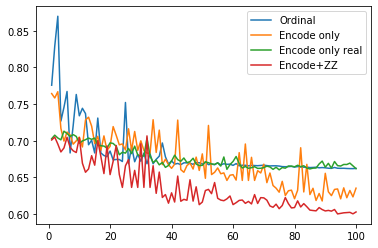

In [75]:
# Get some plot
# Training loss
x_plot = np.arange(1, 101)

plt.plot(x_plot, vqc_ordinal_log, label='Ordinal')
plt.plot(x_plot, vqc_encode_only_log, label='Encode only')
plt.plot(x_plot, vqc_encode_only_real_log, label='Encode only real')
plt.plot(x_plot, vqc_encode_zz_log, label='Encode+ZZ')
plt.legend()